In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import re
from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

Используем модель как бейзлайн, поменяем количество классов с 2 до 4

In [6]:
words = Counter()

for example in dataset['train']['text']:
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(69)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [10]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [11]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    # Добавим выход лосса каждую и эпоху и также accuracy(evaluate) после обучения модели
    print(f'Базовая модель (aggregation_type = {aggregation_type}) accuracy :{evaluate(model, eval_dataloader)}')

Starting training for max
Базовая модель (aggregation_type = max) accuracy :0.9034000039100647
Starting training for mean
Базовая модель (aggregation_type = mean) accuracy :0.9077999591827393


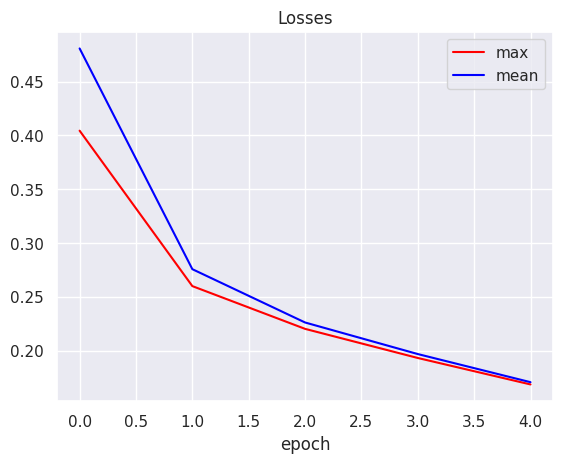

In [12]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.62
Лучшая accuracy для подхода mean: 90.80


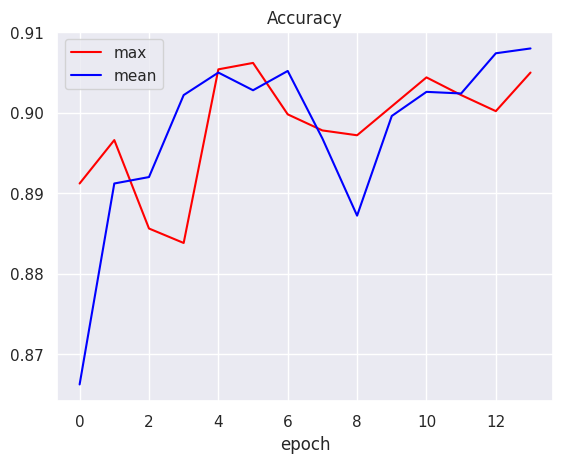

In [13]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [16]:
loss_fn = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
e_acc=evaluate(model, eval_dataloader)
t_acc=evaluate(model, train_dataloader)


In [17]:
print(f"valid accuracy:{e_acc}")
print(f"train accuracy:{t_acc}")

valid accuracy:0.9071999788284302
train accuracy:0.9579333662986755


# Проведение экспериментов 


1)Поменял токенизатор, сделал его полностью кастомным
2)Поменял функции обучения, для удобства обучения и вывода графиков не только для трейна но и для теста
3)Поменял архитетктуру модели, использовал GRU
На каждом шаге подбирал гиперпараметры:размер словаря,dropout,lerning rate,batch size,hidden dim


In [18]:
class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 20):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.extend(['<unk>', '<bos>', '<eos>', '<pad>'])

        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = ['<bos>']
        tokenized_sentence += [
            word2ind.get(word, '<unk>') for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += ['<eos>']

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def ind2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2ind(self, word: str):
        word = word.lower()

        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]

    def encode(self, text):
        result = []
        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        text = text.strip().lower()
        text = ['<bos>'] +text.split()+ ['<eos>']
        for word in text:
            result.append(self.word2ind(word))

        return result

    def get_pad(self):
        return self.word2ind('<pad>')

    def __len__(self):
        return len(self.vocabulary)

In [19]:
def set_seed(seed):
    import numpy as np
    import random
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(0xDEADF00D)


In [20]:
vocab = Vocabulary(dataset['train']['text'])

In [21]:
class WordDataset:
    def __init__(self, sentences,vocab):
        self.data = sentences
        self.vocab=vocab
        self.unk_id = vocab.word2ind('<unk>')
        self.bos_id = vocab.word2ind('<bos>')
        self.eos_id = vocab.word2ind('<eos>')
        self.pad_id = vocab.word2ind('<pad>')


    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += vocab.encode(self.data[idx]['text'])
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=vocab.word2ind('<pad>'), max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [22]:


train_dataset = WordDataset(dataset['train'],vocab)

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx),vocab)

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [23]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True,num_layers=2,dropout=0.15,bidirectional=False)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [24]:
@torch.inference_mode()
def evaluate(model, eval_dataloader,loss_fn,device) -> float:
    
    epoch_losses = []
    
    model.eval()

    predictions = []
    target = []
    for batch in eval_dataloader:
        logits = model(batch['input_ids'])
        predictions.append(logits.argmax(dim=1))
        target.append(batch['label'])
        
        loss = loss_fn(logits, batch['label'])
        epoch_losses.append(loss.item())

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()
    losses=sum(epoch_losses) / len(epoch_losses)

    return accuracy,losses

In [25]:
def train(model: nn.Module,
        data_loader: DataLoader,
        optimizer,
        loss_fn,
        device: torch.device):
    epoch_losses = []
    model.train()
    train_accuracy = []
    for i, batch in enumerate(tqdm(train_dataloader)):

        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = loss_fn(logits, batch['label'])

        loss.backward()
        clipping_value = 1 # arbitrary value of your choosing
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        optimizer.step()

        y=batch['label'].reshape(32).long()
        output=logits.argmax(dim=1)
        train_accuracy.append((output == y).float().mean().item())

        epoch_losses.append(loss.item())

    acc=sum(train_accuracy)/len(train_accuracy)
    losses=sum(epoch_losses) / len(epoch_losses)
    return acc,losses

In [26]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss',color='blue')
    plt.plot(valid_loss, label='Valid loss',color='red')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy',color='blue')
    plt.plot(valid_accuracy, label='Valid accuracy',color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [27]:
from IPython.display import clear_output
def whole_train_valid_cycle(model,threshold=0.95):
    
    
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.word2ind('<pad>'))
    
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)#lr=0.000005
    
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(5):
        train_accuracy,train_loss  = train(model, train_dataloader, optimizer, loss_fn, device)
        valid_accuracy,valid_loss = evaluate(model, eval_dataloader,loss_fn,device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)
        title="GRU"
        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        if valid_accuracy >= threshold:
            break


In [28]:
model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type='max').to(device)


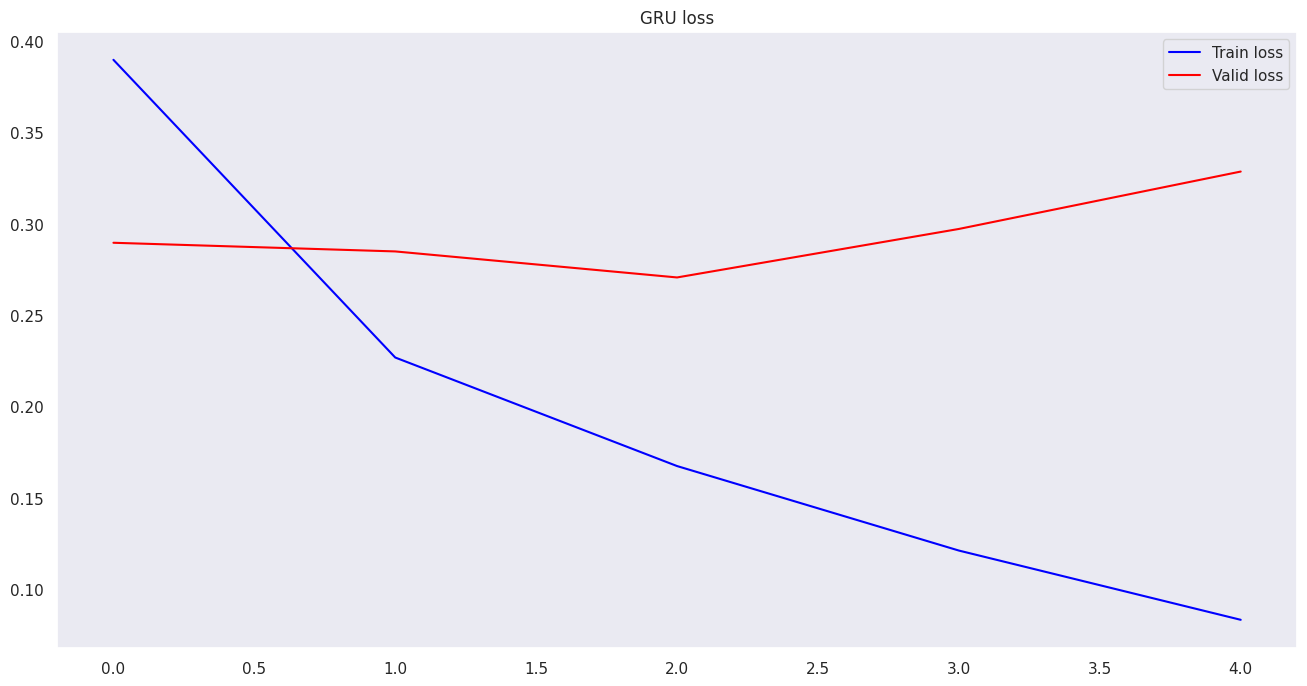

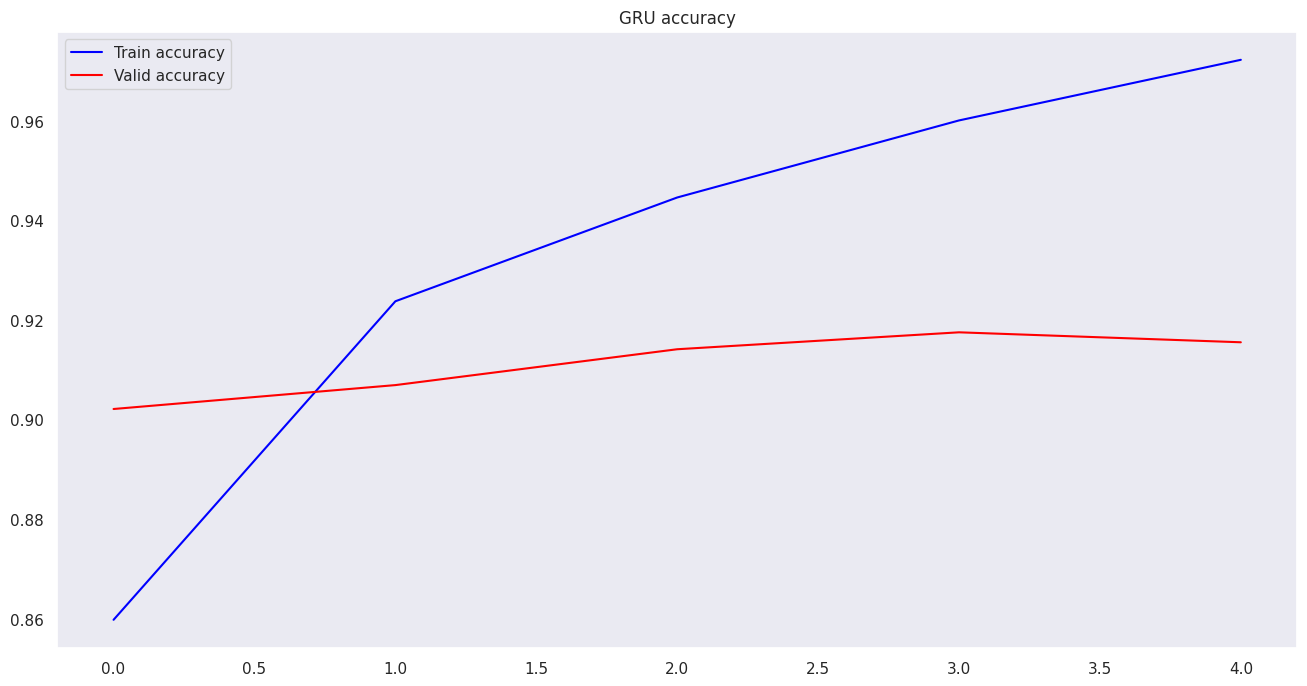

In [29]:
whole_train_valid_cycle(model)

In [30]:
loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.word2ind('<pad>'))
e_acc,e_loss=evaluate(model, eval_dataloader,loss_fn,device)
t_acc,t_loss=evaluate(model, train_dataloader,loss_fn,device)


In [31]:
print(f"valid accuracy:{e_acc}")
print(f"train accuracy:{t_acc}")

valid accuracy:0.9156000018119812
train accuracy:0.9859333634376526


In [32]:
print(f"valid loss:{e_loss}")
print(f"train loss:{t_loss}")

valid loss:0.32886327778962055
train loss:0.044434936882586526


# Описание экспериментов

**Получил качество 0.915
Самый существенный прирост принесло изменение ахитектуры на GRU, а также добавление туда дропаута и увеличение количества слоев. Изменение функции токенизации тоже дало прирост, если выбрать одинаковую частоту равную 25 у моего токенизатора и токенизатора с семинара, то в моем будет на 300 слов меньше. Проведя еще эксперименты с токенизатором я выбрал порог в 20, потолок в 0.915 помог преодолеть тип аггрегации нейронной сети, я не стал обучать по 2 сети с mean  и max по отдельности, гиперпараментры я подбирал с mean, а качество с 0.914 до 0.915 помог преодолеть max
Для удобства я переписал функции трейна и теста, добавил функцию вывода и функцию обучения, также добавил класс словаря. На семинаре качество и лосс меряли на трейне, но я добавил возможность мерять качество и лосс на тесте. Сразу же столкнулся с проблемой, если учеличить количество эпох до 15-25, то лосс начал расти, качество падать, с этим можно было бы побороться, изменив lerning rate и добавив gradient clipping, но качество за 25 эпох не достигло 0.91, хоть оно и продолжало расти, но ждать еще 25 эпох(похоже было что такое количество потребуется, чтоб пробить 0.915) я не стал
**


*Все остальные гиперпараметры либо внесли несущественный вклад, либо ухудшили качество. 
Например batch size = 64,128 уменьшал качество примерно дот 89-90*

# Вывод

Хоть у этой модели есть проблемы с обучением, тк лосс слишком сильно колеблется,
но поиск оптимума не сильно повлияет на генерализующие способности,
а у предудущей модели те же проблемы и качество ниже